#Sistem Rekomendasi Resep Makanan Menggunakan Algoritma Singular Value Decomposition pada Dataset Food.com


Nama : Salsabila Awwaliyyah Lestari

NIM  : 1301204257


Dosen Pembimbing : Agung Toto Wibowo, S.T., M.T., Ph.D.

In [ ]:
 pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162648 sha256=0dffb98996c5fa318e2e11a622aa6e4af22bc23f7d1bf89afcb6b2583923d817
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd

#Preprocessing Data

In [ ]:
!gdown 1zWHJgBWuUcIZQSbdqvjshC7orLhq6YNY

Downloading...
From (original): https://drive.google.com/uc?id=1zWHJgBWuUcIZQSbdqvjshC7orLhq6YNY
From (redirected): https://drive.google.com/uc?id=1zWHJgBWuUcIZQSbdqvjshC7orLhq6YNY&confirm=t&uuid=1ca950de-aa04-4af4-9e6e-9b72a083d4b7
To: /content/RAW_interactions.csv
100% 349M/349M [00:06<00:00, 50.3MB/s]


In [ ]:
dfi = pd.read_csv('RAW_interactions.csv')

###Hapus kolom tak terpakai

In [ ]:
dfii = dfi.drop(['date','review'], axis = 1)
dfii.count()

user_id      1132367
recipe_id    1132367
rating       1132367
dtype: int64

### Hapus Rating nol

In [ ]:
# Menghapus baris dengan rating nol
df_i = dfii[dfii['rating'] != 0]

<Axes: ylabel='rating'>

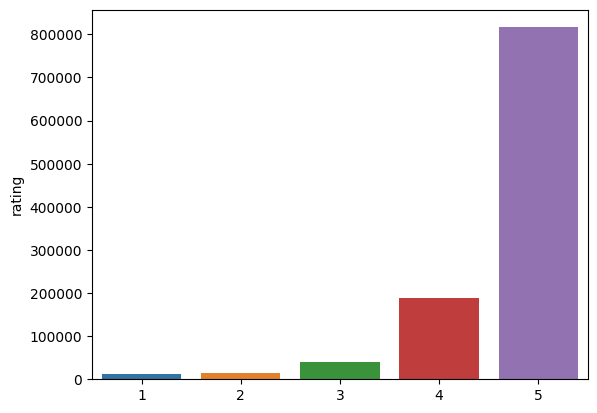

In [ ]:
import seaborn as sns
sns.barplot(x=df_i.rating.value_counts().index, y=df_i.rating.value_counts())

#Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_i[['user_id', 'recipe_id', 'rating']], reader)
kf = KFold(n_splits=5)

In [ ]:
# Memisahkan trainset menjadi data train dan data validasi
X_train, X_test, y_train, y_test = train_test_split(df_i[['user_id', 'recipe_id']], df_i['rating'], test_size=0.2, random_state=42)

# Menggabungkan hasil oversampling ke dalam satu DataFrame
trainset = pd.concat([X_train, pd.Series(y_train, name='rating')], axis=1)

# Menggabungkan hasil oversampling ke dalam satu DataFrame untuk testset
testset = pd.concat([X_test, pd.Series(y_test, name='rating')], axis=1)
testset_1 = Dataset.load_from_df(testset[['user_id', 'recipe_id', 'rating']], reader)

# Save trainset to CSV
trainset.to_csv('trainset.csv', index=False)

# Save testset to CSV
testset.to_csv('testset.csv', index=False)

# Cross Validation

In [ ]:
import numpy as np

from surprise.model_selection import KFold
from surprise.accuracy import rmse, mae
from surprise import Dataset, Reader, SVD, dump
from surprise.model_selection import KFold


from sklearn.metrics import ndcg_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from imblearn.over_sampling import RandomOverSampler


In [ ]:
# Tentukan parameter yang akan diuji
param_grid = {
    'n_epochs': [10, 20,50 ],
    'n_factors': [100],
    'lr_all': [0.005, 0.010, 0.025],
    'reg_all': [0.02, 0.05],
}

Pada code dibawah ini akan dilakukan cross validation untuk mencari best parameter untuk model.

Disini juga akan penampilkan hasil performansinya per looping dan menyimpannya dalam file csv



In [ ]:
# Membuat objek Dataset dari DataFrame trainset dan testset (menggunakan Surprise library)
trainset_1 = Dataset.load_from_df(trainset[['user_id', 'recipe_id', 'rating']], reader)
testset_1 = Dataset.load_from_df(testset[['user_id', 'recipe_id', 'rating']], reader)

# Inisialisasi objek RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Inisialisasi K-Fold
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42)

# DataFrame untuk menyimpan hasil evaluasi
results_dfs = []

# Iterasi melalui setiap parameter
for n_epochs in param_grid['n_epochs']:
    for n_factors in param_grid['n_factors']:
        for lr_all in param_grid['lr_all']:
            for reg_all in param_grid['reg_all']:
                # DataFrame untuk menyimpan hasil evaluasi untuk parameter ini
                parameter_results_df = pd.DataFrame(columns=['Fold', 'Recall', 'Precision', 'F1_Score', 'Specificity', 'False_Positive_Rate', 'RMSE', 'MAE', 'NDCG'])

                # Iterasi melalui setiap lipatan
                for i, (train_idx, test_idx) in enumerate(kf.split(trainset_1)):
                    # Mendapatkan DataFrame dari trainset
                    trainset_df = pd.DataFrame(train_idx.all_ratings(), columns=['user_id', 'recipe_id', 'rating'])

                    X_train = pd.DataFrame(trainset_df, columns=['user_id', 'recipe_id', 'rating'])[['user_id', 'recipe_id']]
                    y_train = pd.DataFrame(trainset_df, columns=['user_id', 'recipe_id', 'rating'])['rating']

                    # Melakukan random oversampling hanya pada data train
                    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

                    #Menggabungkan hasil oversampling ke dalam satu DataFrame
                    trainset_resampled = pd.concat([X_train_resampled, y_train_resampled.reset_index(drop=True)], axis=1, names=['user_id', 'recipe_id', 'rating'])


                    # Latih model dengan parameter yang sedang diuji
                    model = SVD(n_epochs=n_epochs, n_factors=n_factors, lr_all=lr_all, reg_all=reg_all)

                    # Melatih model pada data train yang telah di-oversampled
                    model.fit(Dataset.load_from_df(trainset_resampled[['user_id', 'recipe_id', 'rating']], reader).build_full_trainset())


                    # Prediksi model menggunakan dataset testset_1
                    predictions = model.test(testset_1.build_full_trainset().build_testset())

                    true_ratings = [pred.r_ui for pred in predictions]
                    estimated_ratings = [pred.est for pred in predictions]

                    threshold = 3.5

                    # Mengonversi nilai-nilai prediksi menjadi binary berdasarkan threshold
                    binary_true_ratings = [1 if true_rating >= threshold else 0 for true_rating in true_ratings]
                    binary_estimated_ratings = [1 if estimated_rating >= threshold else 0 for estimated_rating in estimated_ratings]


                    # Menghitung confusion matrix
                    cm = confusion_matrix(binary_true_ratings, binary_estimated_ratings)

                    tn, fp, fn, tp = cm.ravel()

                    # Menghitung performansi
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

                    #Hitung nilai ndcg
                    # Konversi ke dalam array untuk perhitungan ndcg
                    continuous_true_ratings = np.array([true_ratings])
                    continuous_estimated_ratings = np.array([estimated_ratings])

                    # Hitung nilai NDCG
                    ndcg = ndcg_score(continuous_true_ratings, continuous_estimated_ratings)

                    # Menghitung RMSE dan MAE
                    rmse_score = rmse(predictions)
                    mae_score = mae(predictions)

                    # Menyimpan hasil evaluasi untuk iterasi ini
                    parameter_results_df = parameter_results_df.append({
                        'n_epochs': n_epochs,
                        'n_factors': n_factors,
                        'lr_all': lr_all,
                        'reg_all': reg_all,
                        'Fold': i+1,
                        'Recall': recall,
                        'Precision': precision,
                        'F1_Score': f1,
                        'Specificity': specificity,
                        'False_Positive_Rate': false_positive_rate,
                        'RMSE': rmse_score,
                        'MAE': mae_score,
                        'NDCG': ndcg
                    }, ignore_index=True)

                # Menambahkan parameter ini ke dalam list hasil evaluasi
                results_dfs.append(parameter_results_df)

                # Gabungkan hasil evaluasi untuk setiap parameter ke dalam satu DataFrame
                result = pd.concat(results_dfs, ignore_index=True)

                # Simpan hasil evaluasi ke dalam file CSV
                result.to_csv(f'results_parameter_{n_epochs}_{n_factors}_{lr_all}_{reg_all}.csv', index=False)


# Gabungkan hasil evaluasi untuk setiap parameter ke dalam satu DataFrame
combined_results_df = pd.concat(results_dfs, ignore_index=True)

# Simpan hasil evaluasi gabungan ke dalam file CSV
combined_results_df.to_csv('combined_evaluation_results.csv', index=False)


In [ ]:
import os
import zipfile

# Simpan semua file CSV hasil evaluasi ke dalam sebuah arsip ZIP
zip_filename = 'evaluation_results.zip'
with zipfile.ZipFile(zip_filename, 'w') as zip_file:
    for filename in os.listdir():
        if filename.endswith('.csv'):
            zip_file.write(filename)

# Tautan untuk mengunduh arsip ZIP
download_link = f'<a href="{zip_filename}" download>Unduh Semua Hasil Evaluasi</a>'

# Cetak tautan untuk digunakan
print(download_link)


#Modelling with best parameter

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.metrics import ndcg_score
import numpy as np
from surprise import Dataset
from surprise import Reader


In [ ]:
!gdown 1hTUzM-d107FU69OuVWXJtRkTua7_ZOnl
!gdown 1L6C4Rc4vtOAFvXmQa6rEXyQUn_BfRyu5
!gdown 1VBWspzeS6oXfhsql95kutmOLJA34fhfZ

Downloading...
From: https://drive.google.com/uc?id=1hTUzM-d107FU69OuVWXJtRkTua7_ZOnl
To: /content/testset.csv
100% 3.36M/3.36M [00:00<00:00, 20.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L6C4Rc4vtOAFvXmQa6rEXyQUn_BfRyu5
To: /content/trainset.csv
100% 13.4M/13.4M [00:00<00:00, 29.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1VBWspzeS6oXfhsql95kutmOLJA34fhfZ
From (redirected): https://drive.google.com/uc?id=1VBWspzeS6oXfhsql95kutmOLJA34fhfZ&confirm=t&uuid=10ab3550-1d1f-4911-8558-e973ef842b86
To: /content/RAW_recipes.csv
100% 295M/295M [00:05<00:00, 49.4MB/s]


In [ ]:
train = pd.read_csv('trainset.csv')
test = pd.read_csv('testset.csv')
df_r = pd.read_csv('RAW_recipes.csv')

In [ ]:
train

,user_id,recipe_id,rating
0,16334,13737,5
1,325801,20482,5
2,1908448,311788,5
3,497077,1985,5
4,335606,89204,5
...,...,...,...
857211,558843,8757,5
857212,168921,57890,5
857213,1216807,214599,4
857214,2376788,76864,4


<Axes: ylabel='rating'>

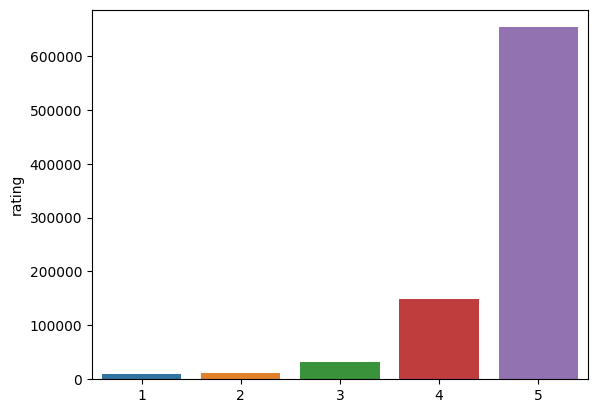

In [ ]:
import seaborn as sns
sns.barplot(x=train.rating.value_counts().index, y=trainset.rating.value_counts())

<Axes: ylabel='rating'>

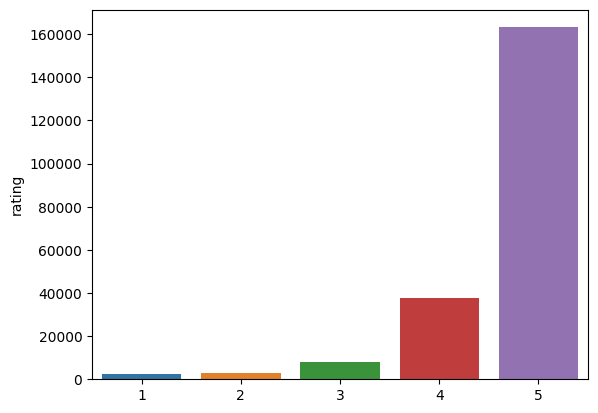

In [ ]:
import seaborn as sns
sns.barplot(x=test.rating.value_counts().index, y=testset.rating.value_counts())

In [ ]:
recipe

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


**Best Parameter**

Dari Hasil code diatas mendapatkan Best parameter dengan
- n_epoch = 10, n_factors = 100, lr_all = 0,005, reg_all = 0,05

In [ ]:
from surprise import Reader, Dataset
import pandas as pd

#Hasil Best Parameter kf = 5
best_parameter = {'n_epochs': 10, 'n_factors':100, 'lr_all': 0.005, 'reg_all':0.05}

reader = Reader()


data_train = Dataset.load_from_df(train[['user_id', 'recipe_id', 'rating']], reader)
trainset = data_train.build_full_trainset()

data_test = Dataset.load_from_df(test[['user_id', 'recipe_id', 'rating']], reader)
testset = data_test.build_full_trainset().build_testset()



# Inisialisasi objek SVD sebagai model
model = SVD(**best_parameter)

model.fit(trainset)

pred_final =  model.test(testset)

true_ratings_final = [pred.r_ui for pred in pred_final]
estimated_ratings_final = [pred.est for pred in pred_final]

threshold = 3.5

# Mengonversi nilai-nilai prediksi menjadi binary berdasarkan threshold
binary_true_ratings_f = [1 if true_rating >= threshold else 0 for true_rating in true_ratings_final]
binary_estimated_ratings_f = [1 if estimated_rating >= threshold else 0 for estimated_rating in estimated_ratings_final]

# Menghitung confusion matrix
cm = confusion_matrix(binary_true_ratings_f, binary_estimated_ratings_f)

tn, fp, fn, tp = cm.ravel()

# Menghitung performansi
recall_final = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_final = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_final = 2 * (precision_final * recall_final) / (precision_final + recall_final) if (precision_final + recall_final) > 0 else 0
specificity_final = tn / (tn + fp) if (tn + fp) > 0 else 0
false_positive_rate_final = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate_final = fn / (fn + tp) if (fn + tp) > 0 else 0


#Hitung nilai ndcg
# Konversi ke dalam format 'continuous-multioutput'
continuous_true_ratings = np.array([true_ratings_final])
continuous_estimated_ratings = np.array([estimated_ratings_final])

# Hitung nilai NDCG
ndcg_score_final = ndcg_score(continuous_true_ratings, continuous_estimated_ratings)

# Menghitung RMSE dan MAE
rmse_score = rmse(pred_final)
mae_score = mae(pred_final)

# Print the result
print(f'Recall: {recall_final}')
print(f'Precision: {precision_final}')
print(f'F1 Score: {f1_final}')
print(f'Specificity Scores: {specificity_final}')
print(f'False Positif Rate: {false_positive_rate_final}')
print(f'False Negatif Rate: {false_negative_rate_final}')
print(f'NDCG Scores: {ndcg_score_final}')
print(f'RMSE: {rmse_score}')
print(f'RMSE: {mae_score}')
print('')
print("")



RMSE: 0.6846
MAE:  0.4423
Recall: 0.9995966135458167
Precision: 0.9372428896287338
F1 Score: 0.9674160579719925
Specificity Scores: 0.004739336492890996
False Positif Rate: 0.995260663507109
False Negatif Rate: 0.00040338645418326694
NDCG Scores: 0.9976190325204406
RMSE: 0.6846190640741038
RMSE: 0.44226618438839266




##Rekomendasi Resep

In [ ]:
def getRecommendations(estimates, items, top_n=10):
    # Membuat salinan DataFrame items
    preds = items.copy()

    # Memeriksa apakah DataFrame kosong
    if preds.empty:
        print("No recommendations available.")
        return

    # Debugging line: mencetak DataFrame preds
    print(preds)
    print("sampe sini")
    print()

    # Mengurutkan DataFrame berdasarkan estimated_rating secara menurun
    sorted_preds = preds.sort_values(by='estimated_rating', ascending=False)

    # Mencetak rekomendasi teratas (top_n) berdasarkan estimated_rating
    print(f'\nTop {top_n} Food recipe recommendations (Sorted) for user_id = {user_id}:')
    for i in range(min(top_n, len(sorted_preds))):
        # Mengambil recipe_id dari indeks baris ke-i dalam DataFrame sorted_preds
        recipe_id = sorted_preds.index[i]
        print(f"Recipe ID:", recipe_id)

        # Memeriksa apakah recipe_id ada dalam DataFrame df_r
        if not df_r[df_r["id"] == recipe_id].empty:
            # Mencetak informasi resep (nama dan estimated_rating)
            print(f'{i+1}. {df_r[df_r["id"] == recipe_id]["name"].values[0]} ({sorted_preds.iloc[i]["estimated_rating"]:.4f})')
            print('')

    # Menghitung dan mencetak nilai NDCG antara preds dan sorted_preds
    ndcg_scores = ndcg_score([preds['estimated_rating'].values], [sorted_preds['estimated_rating'].values])
    print(f'\nNDCG: {ndcg_scores:.4f}')


In [ ]:
# Contoh pemanggilan
user_id = 338232

selected_ui_matrix = df_i[df_i['user_id'] == user_id]
selected_items = selected_ui_matrix.pivot_table(values='rating', index='recipe_id', columns='user_id', fill_value=None)

# Mengumpulkan nilai prediksi 'est' dari list pred_final
estimated_ratings_dict = {pred.iid: pred.est for pred in pred_final}

# Menetapkan nilai rating yang diestimasi ke DataFrame selected_items
selected_items['estimated_rating'] = selected_items.index.map(lambda item: estimated_ratings_dict.get(item, None))

# Menghapus baris dengan nilai NaN pada kolom 'estimated_rating'
selected_items.dropna(subset=['estimated_rating'], inplace=True)

getRecommendations(selected_items['estimated_rating'].tolist(), selected_items)
print()


user_id    338232  estimated_rating
recipe_id                          
17327           5          4.649495
45668           5          4.633964
55255           4          4.747010
69916           4          4.629901
89186           5          4.370235
90003           4          4.488913
107429          5          4.627789
117194          4          4.594098
128069          4          4.561552
135509          4          4.711704
139735          5          4.564973
139807          5          4.984547
140706          4          4.585188
143817          4          4.392273
151551          4          4.485195
155018          5          4.840837
172293          5          4.746042
176227          4          4.656318
197293          3          4.475349
sampe sini


Top 10 Food recipe recommendations (Sorted) for user_id = 338232:
Recipe ID: 139807
1. mashed pumpkin potatoes (4.9845)

Recipe ID: 155018
2. pan roasted broccoli (4.8408)

Recipe ID: 55255
3. banana   ice cream (4.7470)

Recipe ID

In [ ]:
# Contoh pemanggilan
user_id = 304290

selected_ui_matrix = df_i[df_i['user_id'] == user_id]
selected_items = selected_ui_matrix.pivot_table(values='rating', index='recipe_id', columns='user_id', fill_value=None)

# Mengumpulkan nilai prediksi 'est' dari list pred_final
estimated_ratings_dict = {pred.iid: pred.est for pred in pred_final}

# Menetapkan nilai rating yang diestimasi ke DataFrame selected_items
selected_items['estimated_rating'] = selected_items.index.map(lambda item: estimated_ratings_dict.get(item, None))

# Menghapus baris dengan nilai NaN pada kolom 'estimated_rating'
selected_items.dropna(subset=['estimated_rating'], inplace=True)

getRecommendations(selected_items['estimated_rating'].tolist(), selected_items)
print()

user_id    304290  estimated_rating
recipe_id                          
6723            3          4.577034
7413            4          4.667472
8701            5          4.772381
13961           4          5.000000
14433           5          4.872457
17251           5          4.801249
18816           5          4.547729
25897           4          4.530720
26820           4          4.896116
27210           5          4.705287
27733           5          4.442143
31207           5          4.590936
34110           4          4.457853
38629           4          4.443678
39900           4          4.765224
43072           5          4.592887
48029           5          4.788554
51780           4          4.610479
52624           5          4.651227
63689           5          4.854380
71739           5          4.591504
73033           5          4.636186
79595           5          4.784018
82102           5          4.655946
83602           5          4.520665
84247           5          4